## Import Libraries

In [1]:
import random
import numpy as np
from copy import deepcopy
from dataclasses import dataclass
import pandas as pd
import math
import networkx as nx
import time
from sklearn.ensemble import RandomForestRegressor
import collections

## Define Functions

In [15]:
def core_link(adjacencyMatrix,core1,core2): 
    
    '''Returns 1 if it satisfies the constrain that a link 
    can no longer than 4 units and returns 0 otherwise'''
    
    #Dijkstra_path = []
    networkAdjacency=nx.from_numpy_matrix(adjacencyMatrix,create_using=nx.DiGraph())
    #Dijkstra_path=nx.dijkstra_path(networkAdjacency,core1,core2)    # Get the shortest path between cores
    Dijkstra_path=nx.shortest_path_length(networkAdjacency,core1,core2)
    if Dijkstra_path > 4:
        return 0
    else:
        return 1
    
def generate_mesh():
    
    '''Returns a list of cores connected to each other in a mesh'''
    
    core_connected=[]
    for i in range(63):
        # Since cores in the last row are connected to next core and the one above 
        if i in [56,57,58,59,60,61,62,63]:  
            core_connected.append([i,i+1])
        # Cores on extreme right are not connected to next core, they are connected to the one below
        elif i in [7,15,23,31,39,47,55]:    
            core_connected.append([i,i+8])
        # Cores are connected to the next and the one below that core
        else:
            core_connected.append([i,i+1])
            core_connected.append([i,i+8])
    return core_connected

def adjacency_matrix(coreConnections):
    
    '''Returns an adjacency matrix for the connected cores list.
    Thus, if cores 1 and 8 are connected, row 0, column 8 and row 8, column 0 is made 1.'''
    
    s=(64,64) 
    # Since, the cores are arranged in 8x8 grid, 64x64 matrix is created of all zeros
    mesh_matrix=np.zeros(s)
    # The matrix is written with 1 where connections are present
    for connect in coreConnections:
            mesh_matrix[connect[0]][connect[1]]=1
            mesh_matrix[connect[1]][connect[0]]=1
    return mesh_matrix

def link_move(core1,core2,Scurr,Tcurr):
    
    '''Returns a new adjacency matrix by performing link movement between desired cores following the 
    constrains that each new design has the same amount of links (112) and each core can have at most 
    7 links. In order to do this, the number of links for core 2 is counted and if it is 7, then perturb 
    function is called again which generated random cores again. To main 112 links in the design, one of 
    the core 1 connections are destroyed only if that core is connected to cores other than core 1 else 
    perturb function is called again.'''
    
    # Create a copy so that new connections are not made in the original adjacency matrix
    Scurr_copy=deepcopy(Scurr)   
    core_connect=[]
    coreCount=-1
    nLinks=np.sum(Scurr_copy[core2])   # number of cores core 2 is connected to
    if nLinks < 7:
        for i in Scurr_copy[core1]:
            coreCount+=1
            if i==1:
                core_connect.append(coreCount)
        # Randomly choose a core connected to core 1 to destroy the link between them 
        core_link_destroy=random.choice(core_connect)
        # check if the core chosen for destroying connection has only one connection
        if (np.sum(Scurr_copy[core_link_destroy])==1):  
            perturb(Scurr,Tcurr)
        else:
            # Make new links between core 1 and core 2 and destroy one of the link of core 1
            Scurr_copy[core1][core_link_destroy]=0
            Scurr_copy[core_link_destroy][core1]=0
            Scurr_copy[core1][core2]=1
            Scurr_copy[core2][core1]=1                
    else:
        perturb(Scurr,Tcurr)
    return Scurr_copy

def tile_swap(core1,core2,Tcurr):
    
    '''Returns a task vectors where taks are swapped'''
    
    Tcurr_copy=deepcopy(Tcurr)
    Tcurr_copy[core1], Tcurr_copy[core2] = Tcurr_copy[core2], Tcurr_copy[core1]
    return Tcurr_copy

def perturb(Scurr,Tcurr):
    
    '''Returns a new adjacency matrix and task vector as a result of performing link
    movement or task swap function randomly between the cores chosen randomly.'''
    
    # randomly generate 0 or 1 and call link_move() if 0 else call tile_swap()
    link_or_tile = random.randint(0,1)
    valid_core=0
    # randomly generate 2 cores to be generated or tasks to be swapped
    core1=random.randint(0,63)
    core2=random.randint(0,63)
    # create copy of original adjacency matrix to avoid changes in the original one
    Snew = deepcopy(Scurr)
    Tnew = deepcopy(Tcurr)
    # Call perturb again if the cores generated are same and if the cores are already connected
    if (Scurr[core1][core2]==1 or core1==core2):
        perturb(Scurr,Tcurr)
    else:
        if link_or_tile==0:
            # check whether core2 can be connected to core 1 
            #(i.e. if the constraints of having maximum 4 links between them is satisfied) 
            # else call pertrub again to generate random cores again.
            valid_core=core_link(Scurr,core1,core2)
            if valid_core == 1:
                Snew=link_move(core1,core2,Scurr,Tcurr)
            elif valid_core == 0:
                perturb(Scurr,Tcurr)
        elif link_or_tile==1:
            # Call tile swap to swap tasks on the task vector 
            Tnew=tile_swap(core1,core2,Tcurr)
    return Snew,Tnew

def generator_euclidean(nNodes,grid):
    
    '''Returns a matrix containing euclidean distance between the cores. 
    Eg. distance between core 0 and core 1 or core 0 and core 8 is 1 as they
    are directly connected and adjacent to each other whereas distance between 
    core 0 and core 9 is 1.414(i.e. sqrt(1+1)).'''
    
    euclideanMatrix = np.zeros((nNodes,nNodes))
    for row in range(nNodes):
        value =row / grid
        xCoordinate = (int)(value)
        yCoordinate = row % grid
        for col in range(nNodes):
            value=col / grid
            x1Coordinate = (int)(value)
            y1Coordinate = col % grid
            xDistance = (x1Coordinate-xCoordinate)**2
            yDistance = (y1Coordinate-yCoordinate)**2
            # Calculate euclidean distance
            euclideanMatrix[row][col] = (xDistance + yDistance)**0.5
    return euclideanMatrix


def calc_hopCount(adjacencyMatrix,nNodes):
    
    '''Returns the hop count matrix which is the total number of cores in the path between the two cores'''
    
    hopCount=np.zeros((nNodes,nNodes))  # Matrix of 64x64 of all zeros
    networkAdjacency=nx.from_numpy_matrix(adjacencyMatrix,create_using=nx.DiGraph())
    for i in range(nNodes):
        for j in range(nNodes):
             # Get the shortest path length for each core to every other core
            hopCount[i][j]=nx.shortest_path_length(networkAdjacency,i,j)  
    return hopCount

def cal_linkLength(adjacencyMatrix,euclidean,nNodes):
    
    '''Returns the link length matrix which is sum of link lengths between the cores.
    The link length is one if cores if cores are connected adjacent to each other else euclidean distance 
    is the link length.'''
    
    linkLength=np.zeros((nNodes,nNodes))
    # This gives the euclidean distance for the cores connected in the given design
    lengthMatrix=np.multiply(adjacencyMatrix,euclidean)    
    networkLength=nx.from_numpy_matrix(lengthMatrix,create_using=nx.DiGraph())
    pathDijkstra=[]
    for i in range(nNodes):
        for j in range(nNodes):
            if i==j:
                linkLength[i][j]=0
            else:
                # get the Dijkstra path between the cores
                pathDijkstra=nx.dijkstra_path(networkLength,i,j)
                source_destination=[]
                pathLength=[]
                for x in range(len(pathDijkstra)-1):
                    source_destination.append([pathDijkstra[x],pathDijkstra[x+1]])
                # Get the length of links from length Matrix for the cores connected in path
                for cores in source_destination:
                    pathLength.append(lengthMatrix[cores[0]][cores[1]])
                # Add the link lengths of the cores connected in Dijkstra path
                linkLength[i][j]=np.sum(pathLength)
    return linkLength

def objective(adjacencyMatrix,taskMatrix,euclidean,traffic_data,nNodes):
    
    '''Returns the cost of the given design using the formula given in the question.'''
    
    hopCountMatrix=np.zeros((nNodes,nNodes))
    linkLengthMatrix=np.zeros((nNodes,nNodes))
    costVector=[]
    cost=0
    costFinal=0
    # get the hop count matrix for the given design
    hopCountMatrix=calc_hopCount(adjacencyMatrix,nNodes)
    # get the link length matrix for the given design
    linkLengthMatrix=cal_linkLength(adjacencyMatrix,euclidean,nNodes) 
    # Calculate total cost for the design
    for i in range(nNodes):
        for j in range(nNodes):
            task=taskMatrix[j]
            # take the traffic data from the task matrix
            cost=((3*hopCountMatrix[i][j] + math.ceil(linkLengthMatrix[i][j])) * traffic_data[task][i])
            costVector.append(cost)
    costFinal=np.sum(costVector)
    return costFinal

def probability(Cnew,Cold,T):
    
    '''Returns a value computed using formula which is used to determine whether to accept 
    the design even if the cost value is greater than previous cost value'''
    
    delta_f = Cnew - Cold
    prob = math.exp(-delta_f/T)
    return prob

def simulatedAnnealing(traffic_data,T,Tth,alpha,numIter):
    
    '''Performs simulated annealing'''
    
    start=time.time()  # get the start time
    nNodes=64
    grid=8
    # Get the euclidean distance matrix
    EuclideanDistance=generator_euclidean(nNodes,grid) 
    euclidean=np.array(EuclideanDistance)    
    # Base Condition which is a mesh
    coreConnections=generate_mesh()
    Scurr=adjacency_matrix(coreConnections)
    Tcurr=[i for i in range(64)]   # vector of values from 0 to 63
    # Calculate cost using objective function for the base design i.e. Mesh
    Ccurr=objective(Scurr,Tcurr,euclidean,traffic_data,nNodes)
    print("Cost function for Mesh",Ccurr)
    # Iterate until the temperature is not less than the threshold
    while T > Tth:
        for i in range(numIter):
            # perform perturbration i.e link movement or tile swap to get new design
            Sneigh,Tneigh = perturb(Scurr,Tcurr)
            # Calculate the cost for the new design
            Cneigh=objective(Sneigh,Tneigh,euclidean,traffic_data,nNodes)
            # check whether the new cost is less than the old one
            if Cneigh < Ccurr:
            # if it is, update the current design with the new one whose cost is less
                Scurr=Sneigh
                Tcurr=Tneigh
                Ccurr=Cneigh
            else:
            # if not, accept the new design if the acceptance probability is greater than
            # a randomly generated number between 0 and 1
                accept = probability(Cneigh,Ccurr,T)
                if accept > random.uniform(0,1):
                    Scurr=Sneigh
                    Tcurr=Tneigh
                    Ccurr=Cneigh        
        # Deprecate the temperature using alpha i.e learning rate 
        T = alpha*T
        #T = round_up(alpha*T,2)
        print("Cost of Design",Ccurr,"Temperature ",T)
    end=time.time()
    print("Total Execution Time:",end-start)
    return Scurr,Tcurr

## Read csv Files

In [13]:
traffic_uniform = pd.read_csv("traffic_uniform.csv", delimiter=",", header=None)
traffic_complement = pd.read_csv("traffic_complement.csv", delimiter=",", header=None)
traffic_rand = pd.read_csv("traffic_rand.csv", delimiter=",", header=None)

## For T=500, alpha=0.9, Number of iterations=100

In [4]:
T = 500
Tth = 0.1
alpha = 0.9
numIter = 100
adjacentMatrix_rand1,taskMatrix_rand=simulatedAnnealing(traffic_rand,T,Tth,alpha,numIter)

Cost function for Mesh 43422.86699857061
Cost of Design 39250.86873236518 Temperature  450.0
Cost of Design 37747.966270857105 Temperature  405.0
Cost of Design 37442.02761533475 Temperature  364.5
Cost of Design 36941.366327024625 Temperature  328.05
Cost of Design 35676.775977441925 Temperature  295.245
Cost of Design 35096.25058256804 Temperature  265.7205
Cost of Design 34606.533475396594 Temperature  239.14845000000003
Cost of Design 34504.32589044847 Temperature  215.23360500000004
Cost of Design 34453.16860761876 Temperature  193.71024450000004
Cost of Design 33942.956381311145 Temperature  174.33922005000005
Cost of Design 34107.75431488054 Temperature  156.90529804500005
Cost of Design 35185.60080325951 Temperature  141.21476824050006
Cost of Design 35099.60663058822 Temperature  127.09329141645006
Cost of Design 34331.54763662454 Temperature  114.38396227480506
Cost of Design 34327.17910327476 Temperature  102.94556604732455
Cost of Design 34210.034041571074 Temperature  92.6

In [6]:
Noc_rand1=nx.from_numpy_matrix(adjacentMatrix_rand1,create_using=nx.DiGraph())
nx.draw(Noc_rand1,node=True)

In [5]:
taskMatrix_rand

[52,
 50,
 44,
 0,
 16,
 40,
 38,
 27,
 46,
 28,
 54,
 1,
 31,
 14,
 60,
 8,
 62,
 58,
 49,
 61,
 32,
 13,
 33,
 59,
 5,
 43,
 23,
 47,
 51,
 11,
 26,
 37,
 2,
 41,
 29,
 56,
 15,
 55,
 4,
 7,
 53,
 20,
 57,
 35,
 45,
 10,
 19,
 39,
 36,
 18,
 6,
 24,
 25,
 63,
 9,
 12,
 22,
 3,
 34,
 21,
 48,
 17,
 42,
 30]

## For T=100, alpha=0.5, Number of iterations=100

In [23]:
T = 100
Tth = 0.1
alpha = 0.5
numIter = 100
adjacentMatrix_rand2,taskMatrix_rand2=simulatedAnnealing(traffic_rand,T,Tth,alpha,numIter)

Cost function for Mesh 43422.86699857061
Cost of Design 36667.19471020775 Temperature  50.0
Cost of Design 33866.979855350764 Temperature  25.0
Cost of Design 32587.218947804897 Temperature  12.5
Cost of Design 32383.09941183881 Temperature  6.25
Cost of Design 31711.561346454324 Temperature  3.125
Cost of Design 31391.872998716535 Temperature  1.5625
Cost of Design 31239.43358815713 Temperature  0.78125
Cost of Design 31112.532369932862 Temperature  0.390625
Cost of Design 30768.41993643938 Temperature  0.1953125
Cost of Design 30667.99220699269 Temperature  0.09765625
Total Execution Time: 466.9777183532715


In [24]:
Noc_rand2=nx.from_numpy_matrix(adjacentMatrix_rand2,create_using=nx.DiGraph())
nx.draw(Noc_rand2,node=True)

In [25]:
taskMatrix_rand2

[50,
 62,
 12,
 44,
 42,
 8,
 1,
 60,
 53,
 34,
 16,
 18,
 49,
 54,
 58,
 28,
 2,
 25,
 20,
 59,
 32,
 33,
 5,
 47,
 61,
 43,
 37,
 6,
 56,
 38,
 13,
 14,
 4,
 57,
 46,
 23,
 51,
 11,
 63,
 48,
 36,
 19,
 29,
 24,
 40,
 41,
 0,
 17,
 15,
 3,
 26,
 45,
 30,
 21,
 55,
 52,
 27,
 35,
 39,
 31,
 7,
 10,
 22,
 9]

## For T=100, alpha=0.9, Number of iterations=200

In [26]:
T = 100
Tth = 0.1
alpha = 0.9
numIter = 200
adjacentMatrix_rand3,taskMatrix_rand3=simulatedAnnealing(traffic_rand,T,Tth,alpha,numIter)

Cost function for Mesh 43422.86699857061
Cost of Design 33548.067448831425 Temperature  90.0
Cost of Design 32717.70830430302 Temperature  81.0
Cost of Design 32682.70756197106 Temperature  72.9
Cost of Design 32258.916941821353 Temperature  65.61000000000001
Cost of Design 32191.201710203524 Temperature  59.049000000000014
Cost of Design 32273.809056680544 Temperature  53.144100000000016
Cost of Design 32421.502804212392 Temperature  47.829690000000014
Cost of Design 32084.724538644048 Temperature  43.04672100000001
Cost of Design 31843.15234954131 Temperature  38.742048900000015
Cost of Design 31578.525371445256 Temperature  34.86784401000001
Cost of Design 31880.51267860503 Temperature  31.381059609000012
Cost of Design 31797.84464106345 Temperature  28.242953648100013
Cost of Design 31522.15974532444 Temperature  25.41865828329001
Cost of Design 31567.244353788243 Temperature  22.87679245496101
Cost of Design 31425.361645818433 Temperature  20.58911320946491
Cost of Design 31254.44

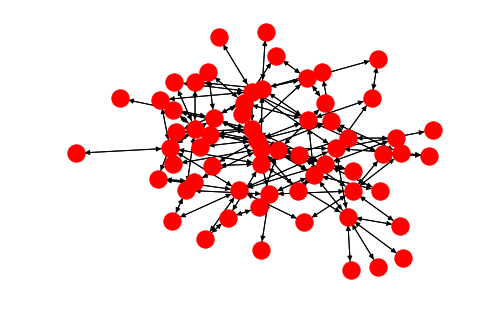

In [27]:
Noc_rand3=nx.from_numpy_matrix(adjacentMatrix_rand3,create_using=nx.DiGraph())
nx.draw(Noc_rand3,node=True)

In [28]:
taskMatrix_rand3

[50,
 16,
 38,
 1,
 60,
 40,
 58,
 8,
 22,
 33,
 13,
 34,
 51,
 55,
 18,
 14,
 41,
 43,
 47,
 28,
 31,
 4,
 23,
 62,
 49,
 15,
 59,
 45,
 56,
 0,
 10,
 27,
 2,
 39,
 61,
 53,
 25,
 32,
 52,
 26,
 54,
 3,
 37,
 29,
 35,
 57,
 11,
 9,
 21,
 36,
 20,
 24,
 7,
 19,
 5,
 17,
 44,
 6,
 42,
 48,
 63,
 12,
 46,
 30]

## Random Traffic (T=100, alpha=0.9, Number of iterations=100)

In [7]:
T = 100
Tth = 0.1
alpha = 0.9
numIter = 100
adjacentMatrix_rand4,taskMatrix_rand4=simulatedAnnealing(traffic_rand,T,Tth,alpha,numIter)

Cost function for Mesh 43422.86699857061
Cost of Design 40053.136479314344 Temperature  90.0
Cost of Design 38203.22146610942 Temperature  81.0
Cost of Design 36829.45133353035 Temperature  72.9
Cost of Design 36360.50959551959 Temperature  65.61000000000001
Cost of Design 34973.018598889714 Temperature  59.049000000000014
Cost of Design 33277.034092547015 Temperature  53.144100000000016
Cost of Design 32839.85883359013 Temperature  47.829690000000014
Cost of Design 32397.27765472606 Temperature  43.04672100000001
Cost of Design 32212.3546081112 Temperature  38.742048900000015
Cost of Design 32180.552379429006 Temperature  34.86784401000001
Cost of Design 32210.474295792825 Temperature  31.381059609000012
Cost of Design 32166.018268608503 Temperature  28.242953648100013
Cost of Design 32266.680162439057 Temperature  25.41865828329001
Cost of Design 31698.280708613936 Temperature  22.87679245496101
Cost of Design 31731.585888742382 Temperature  20.58911320946491
Cost of Design 31685.923

In [8]:
Noc_rand4=nx.from_numpy_matrix(adjacentMatrix_rand4,create_using=nx.DiGraph())
nx.draw(Noc_rand4,node=True)

In [9]:
taskMatrix_rand4

[46,
 36,
 38,
 56,
 28,
 40,
 1,
 55,
 44,
 62,
 3,
 21,
 35,
 58,
 47,
 8,
 4,
 13,
 20,
 49,
 33,
 32,
 23,
 17,
 54,
 15,
 10,
 31,
 59,
 61,
 60,
 27,
 50,
 51,
 43,
 37,
 11,
 39,
 0,
 14,
 30,
 42,
 2,
 53,
 52,
 57,
 26,
 18,
 24,
 41,
 29,
 45,
 5,
 25,
 19,
 12,
 16,
 34,
 48,
 6,
 63,
 22,
 9,
 7]

## Uniform Traffic (T=100, alpha=0.9, Number of iterations=100)

In [16]:
T = 100
Tth = 0.1
alpha = 0.9
numIter = 100
adjacentMatrix_uniform,taskMatrix_uniform=simulatedAnnealing(traffic_uniform,T,Tth,alpha,numIter)

Cost function for Mesh 34384.451593398655
Cost of Design 28474.45306326267 Temperature  90.0
Cost of Design 26172.62108798706 Temperature  81.0
Cost of Design 25958.74961345691 Temperature  72.9
Cost of Design 25945.12709303511 Temperature  65.61000000000001
Cost of Design 26210.18859504239 Temperature  59.049000000000014
Cost of Design 26264.38165161408 Temperature  53.144100000000016
Cost of Design 25916.78202257389 Temperature  47.829690000000014
Cost of Design 25784.809257579116 Temperature  43.04672100000001
Cost of Design 25712.350974412577 Temperature  38.742048900000015
Cost of Design 25609.457848200822 Temperature  34.86784401000001
Cost of Design 25842.03327255979 Temperature  31.381059609000012
Cost of Design 25998.334112483153 Temperature  28.242953648100013
Cost of Design 26028.482442649052 Temperature  25.41865828329001
Cost of Design 26122.055733940753 Temperature  22.87679245496101
Cost of Design 25843.411484899087 Temperature  20.58911320946491
Cost of Design 25825.474

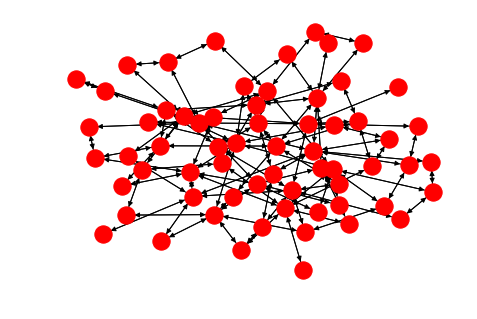

In [17]:
Noc_uniform=nx.from_numpy_matrix(adjacentMatrix_uniform,create_using=nx.DiGraph())
nx.draw(Noc_uniform,node=True)

In [18]:
taskMatrix_uniform

[31,
 46,
 51,
 59,
 36,
 52,
 50,
 44,
 48,
 54,
 2,
 61,
 58,
 57,
 60,
 10,
 22,
 63,
 40,
 39,
 37,
 18,
 17,
 45,
 11,
 53,
 43,
 62,
 55,
 1,
 41,
 16,
 42,
 5,
 24,
 38,
 30,
 23,
 34,
 4,
 47,
 21,
 27,
 9,
 49,
 56,
 8,
 3,
 14,
 6,
 12,
 15,
 26,
 0,
 20,
 35,
 13,
 25,
 7,
 32,
 29,
 33,
 28,
 19]

## Complement Traffic (T=100, alpha=0.9, Number of iterations=100)

In [20]:
T = 100
Tth = 0.1
alpha = 0.9
numIter = 100
adjacentMatrix_complement,taskMatrix_complement=simulatedAnnealing(traffic_complement,T,Tth,alpha,numIter)

Cost function for Mesh 10052.9357927789
Cost of Design 8418.479498663837 Temperature  90.0
Cost of Design 7637.3363801653795 Temperature  81.0
Cost of Design 7342.164031144027 Temperature  72.9
Cost of Design 7615.8982670305 Temperature  65.61000000000001
Cost of Design 7649.945818253844 Temperature  59.049000000000014
Cost of Design 7725.922278829907 Temperature  53.144100000000016
Cost of Design 7870.99316749685 Temperature  47.829690000000014
Cost of Design 7939.423161290423 Temperature  43.04672100000001
Cost of Design 7933.498629020206 Temperature  38.742048900000015
Cost of Design 7768.3918379128345 Temperature  34.86784401000001
Cost of Design 7758.759901086963 Temperature  31.381059609000012
Cost of Design 7865.909571459519 Temperature  28.242953648100013
Cost of Design 7923.453160290548 Temperature  25.41865828329001
Cost of Design 7865.367479424989 Temperature  22.87679245496101
Cost of Design 7887.056095223511 Temperature  20.58911320946491
Cost of Design 7817.459910751579 T

In [21]:
Noc_complement=nx.from_numpy_matrix(adjacentMatrix_complement,create_using=nx.DiGraph())
nx.draw(Noc_complement,node=True)

In [22]:
taskMatrix_complement

[44,
 37,
 62,
 34,
 59,
 58,
 57,
 49,
 55,
 61,
 63,
 45,
 33,
 50,
 51,
 40,
 29,
 12,
 52,
 54,
 43,
 42,
 41,
 32,
 39,
 53,
 36,
 28,
 47,
 20,
 27,
 24,
 31,
 46,
 30,
 23,
 35,
 56,
 25,
 26,
 60,
 22,
 21,
 7,
 19,
 0,
 17,
 8,
 15,
 38,
 13,
 48,
 9,
 10,
 3,
 16,
 4,
 6,
 5,
 14,
 11,
 2,
 1,
 18]